In [1]:
from keras.models import Sequential
#Import from keras_preprocessing not from keras.preprocessing
from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization, Rescaling, InputLayer
from keras.layers import Conv2D, MaxPooling2D, Conv3D
from tensorflow.keras.applications.xception import Xception, preprocess_input, decode_predictions
from keras.utils import get_file, load_img, img_to_array
from keras.callbacks import ModelCheckpoint
from keras import regularizers, optimizers, Input
from IPython.display import Image, display
import pandas as pd
import numpy as np
from keras.optimizers import RMSprop, Adam
import ast
from sklearn.metrics import cohen_kappa_score
from keras import backend as K
import random
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.preprocessing import MultiLabelBinarizer
import os
import cv2
import re
import tensorflow as tf
from sklearn.metrics import f1_score
from keras.applications import ResNet50, VGG19, DenseNet121
from tensorflow.keras.utils import Sequence
from tensorflow.keras.models import Model
from keras.saving import load_model
import pickle

2023-10-18 15:20:30.915433: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
X_train = np.load('./Datasets/X_train.npy')
X_val = np.load('./Datasets/X_val.npy')
y_train = np.load('./Datasets/y_train.npy')
y_val = np.load('./Datasets/y_val.npy')
with open('./Datasets/class_weights.pkl', 'rb') as file:
    loaded_class_weights = pickle.load(file)

In [3]:
IMG_SHAPE = X_train[0].shape
IMG_SHAPE

(224, 224, 3)

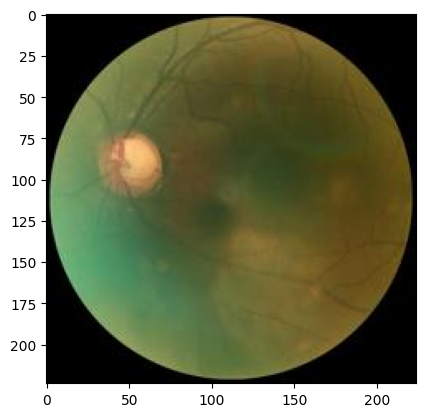

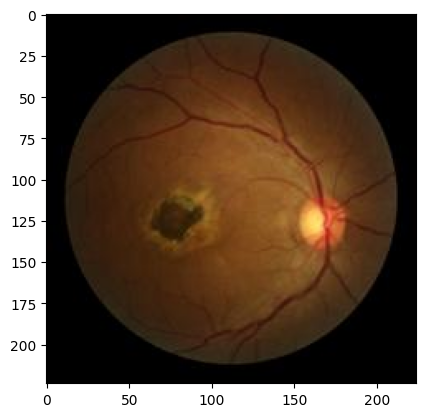

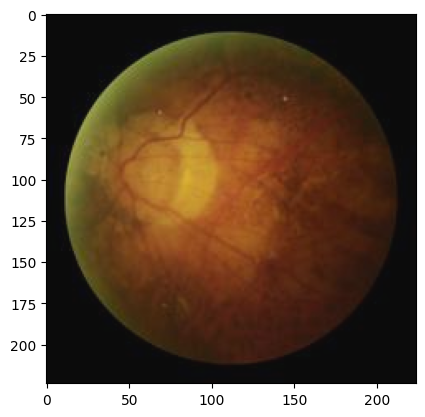

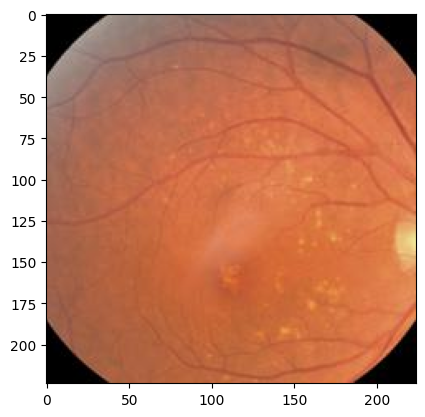

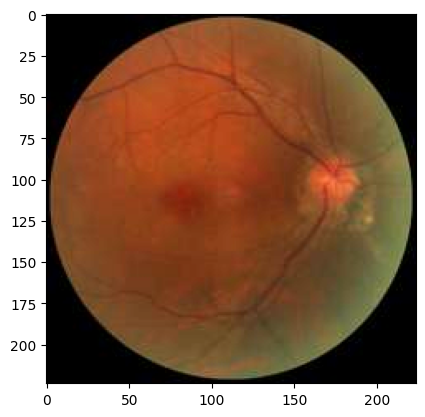

In [4]:
#plot X_train of augmented dataset
for i in range(5):
    plt.imshow(X_train[i])
    plt.show()

In [5]:
base_model = DenseNet121(include_top = False, weights = 'imagenet', input_shape = IMG_SHAPE)
base_model.trainable = False
model= Sequential()
model.add(InputLayer(input_shape = IMG_SHAPE))
model.add(base_model)
model.add(Flatten())
model.add(Dense(256,activation=('relu'))) 
model.add(Dropout(.2))
model.add(Dense(128,activation=('relu')))
model.add(Dropout(.2))
model.add(Dense(8,activation=('sigmoid')))

# Sanity check
print(f"\nModel input shape:\n{model.input_shape}\nModel output shape:\n"\
f"{model.output_shape}\n\n\nModel summary:") 
model.summary()

29084464/29084464 [==============================] - 2s 0us/step

Model input shape:
(None, 224, 224, 3)
Model output shape:
(None, 8)


Model summary:
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 7, 7, 1024)        7037504   
                                                                 
 flatten (Flatten)           (None, 50176)             0         
                                                                 
 dense (Dense)               (None, 256)               12845312  
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dropout_1 (Dropout)         (None, 

In [6]:
base_model.summary()

Model: "densenet121"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 230, 230, 3)          0         ['input_1[0][0]']             
 g2D)                                                                                             
                                                                                                  
 conv1/conv (Conv2D)         (None, 112, 112, 64)         9408      ['zero_padding2d[0][0]']      
                                                                                                  
 conv1/bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1/conv[0][0]']

# For the Grad-CAM

# Back to the model

In [7]:
# Model is saved at the end of every epoch, if it's the best seen so far.
checkpoint_filepath = './Checkpointtest'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [8]:
#Initializing the hyperparameters
batch_size= 2**6
initial_epochs=2 #15
learn_rate=0.001
adam = Adam(learning_rate=learn_rate)

In [9]:
class CustomDataGenerator(Sequence):
    def __init__(self, X, y, batch_size, class_weights):
        self.X = X
        self.y = y
        self.batch_size = batch_size
        self.class_weights = class_weights

    def __len__(self):
        return int(np.ceil(len(self.X) / self.batch_size))

    def __getitem__(self, index):
        batch_X = self.X[index * self.batch_size:(index + 1) * self.batch_size]
        batch_y = self.y[index * self.batch_size:(index + 1) * self.batch_size]
        return batch_X, batch_y

    def on_epoch_end(self):
        # Optionally shuffle your data here
        pass

train_generator = CustomDataGenerator(X_train, y_train, batch_size, loaded_class_weights)

In [10]:
def f1_score_metric(y_true, y_pred):
    y_pred_binary = K.round(y_pred)
    
    true_positives = K.sum(K.round(K.clip(y_true * y_pred_binary, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred_binary, 0, 1)))
    actual_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (actual_positives + K.epsilon())
    
    f1 = 2 * (precision * recall) / (precision + recall + K.epsilon())
    
    return f1


def cohen_kappa_metric(y_true, y_pred):
    y_pred_binary = K.round(y_pred)

    observed_agreement = K.mean(K.equal(y_true, y_pred_binary))
    
    expected_agreement = K.mean(y_true) * K.mean(y_pred_binary) + (1 - K.mean(y_true)) * (1 - K.mean(y_pred_binary))
    
    kappa = (observed_agreement - expected_agreement) / (1 - expected_agreement)

    return kappa


In [11]:

model.compile(optimizer=adam,loss='binary_crossentropy',metrics=['AUC', 'accuracy', f1_score_metric, cohen_kappa_metric])


history = model.fit(train_generator,
                    epochs=initial_epochs,
                    validation_data=(X_val,y_val),
                    steps_per_epoch= 3, #len(X_train)/batch_size,
                    validation_steps=len(X_val),
                    callbacks=[model_checkpoint_callback],
                    verbose = 1)


Epoch 1/2
3/3 [==============================] - ETA: 0s - loss: 3.2972 - auc: 0.5682 - accuracy: 0.1927 - f1_score_metric: 0.2648 - cohen_kappa_metric: 0.0963INFO:tensorflow:Assets written to: ./Checkpointtest/assets


INFO:tensorflow:Assets written to: ./Checkpointtest/assets


3/3 [==============================] - 118s 53s/step - loss: 3.2972 - auc: 0.5682 - accuracy: 0.1927 - f1_score_metric: 0.2648 - cohen_kappa_metric: 0.0963 - val_loss: 3.4828 - val_auc: 0.6515 - val_accuracy: 0.3500 - val_f1_score_metric: 0.2473 - val_cohen_kappa_metric: 0.2457
Epoch 2/2
3/3 [==============================] - ETA: 0s - loss: 3.5800 - auc: 0.6220 - accuracy: 0.3385 - f1_score_metric: 0.2782 - cohen_kappa_metric: 0.1899INFO:tensorflow:Assets written to: ./Checkpointtest/assets


INFO:tensorflow:Assets written to: ./Checkpointtest/assets


3/3 [==============================] - 101s 48s/step - loss: 3.5800 - auc: 0.6220 - accuracy: 0.3385 - f1_score_metric: 0.2782 - cohen_kappa_metric: 0.1899 - val_loss: 2.0644 - val_auc: 0.6694 - val_accuracy: 0.5160 - val_f1_score_metric: 0.2247 - val_cohen_kappa_metric: 0.2138


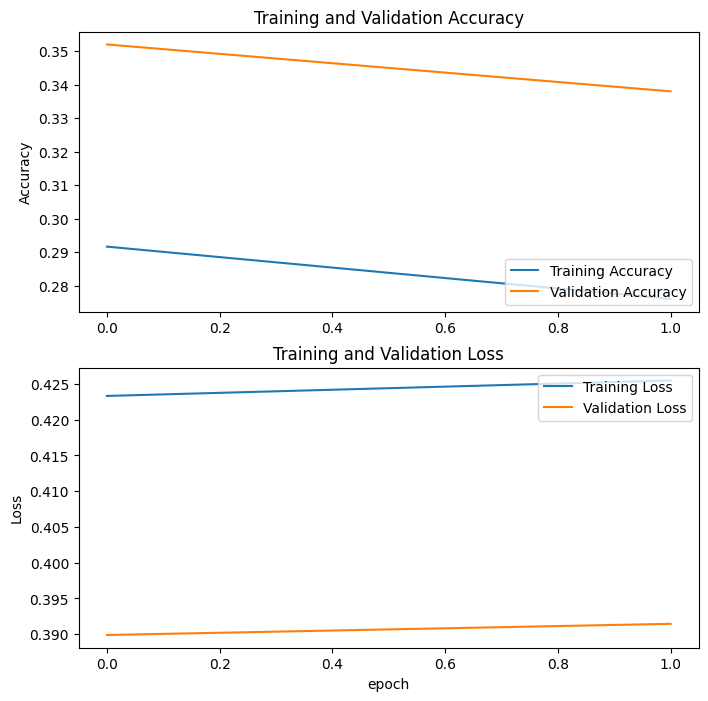

In [76]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

f1_score = history.history['f1_score_metric']
val_f1_score = history.history['val_f1_score_metric']

cohen_kappa = history.history['cohen_kappa_metric']
val_cohen_kappa = history.history['val_cohen_kappa_metric']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
# plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Loss')
# plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# _ , accuracy = model.evaluate(x=X_test,y=y_test,batch_size= batch_size,verbose=1)
# print(f'Model accuracy on test set: {round(accuracy,3)*100}%')

In [21]:
testdfstart= pd.read_csv('XYZ_ODIR.csv')
testdfstart

,ID,N,D,G,C,A,H,M,O
0,937,0,0,0,0,0,0,0,0
1,967,0,0,0,0,0,0,0,0
2,988,0,0,0,0,0,0,0,0
3,995,0,0,0,0,0,0,0,0
4,1000,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
495,4787,0,0,0,0,0,0,0,0
496,4788,0,0,0,0,0,0,0,0
497,4789,0,0,0,0,0,0,0,0
498,4791,0,0,0,0,0,0,0,0


In [22]:
testdf = pd.DataFrame(np.repeat(testdfstart.values, 2, axis=0))
testdf.columns = testdfstart.columns

def append_extension(fn, side):
    return f"{fn}_{side}.jpg"

testdf['Side'] = testdf.index % 2

testdf['ID number'] = testdf.loc[:, 'ID']

testdf['ID number'] = testdf.apply(lambda row: append_extension(row['ID number'], 'left' if row['Side'] == 0 else 'right'), axis=1)

testdf.drop(columns=['Side'], inplace=True)

In [23]:
testdf = testdf[['ID', 'ID number', 'A', 'C', 'D', 'G', 'H', 'M', 'N', 'O']]

In [24]:
test_dir = './squared_and_cropped_dataset_test/'
test_img = [os.path.join(test_dir, i) for i in os.listdir(test_dir)]
img_size = 224

In [25]:
# Form the test labels
X_test = []
for image in tqdm(test_img):
    try:
        img = cv2.imread(image)
        if img is not None:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB
            img = cv2.normalize(img, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
            X_test.append(img)
    except:
        continue

100%|██████████| 1000/1000 [00:01<00:00, 679.76it/s]


In [29]:
X_test = np.asarray(X_test, dtype=np.float32)

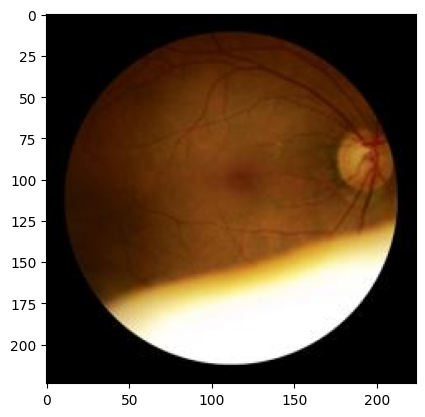

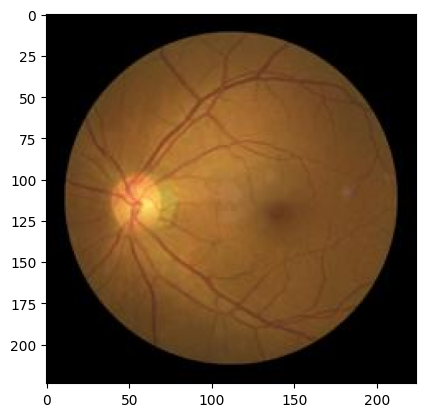

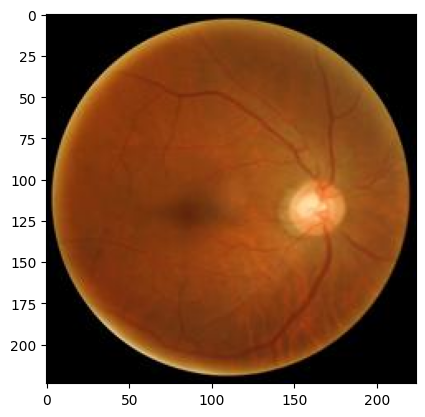

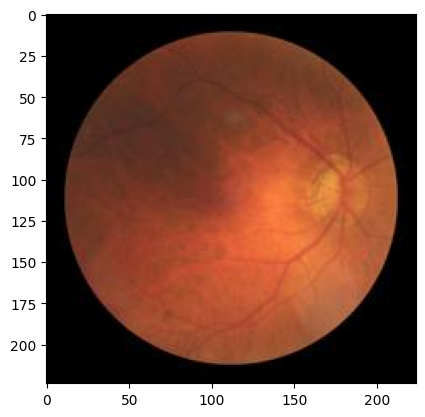

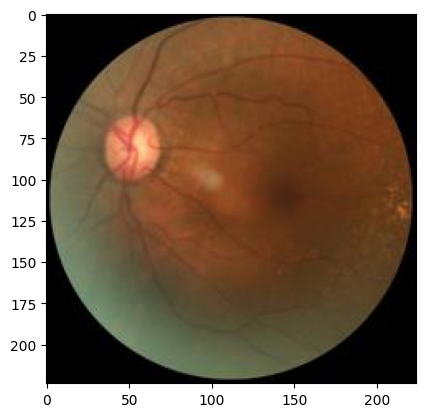

In [26]:
#plot X_train of augmented dataset
for i in range(5):
    plt.imshow(X_test[i])
    plt.show()

In [30]:
model = load_model('./CheckpointResNet50/')
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dense (Dense)               (None, 256)               25690368  
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 8)                 1

In [31]:
batch_size=2**6
# y_test = model.predict(X_test, steps=len(testdf)/batch_size)
y_test = model.predict(X_test, steps=15)

15/15 [==============================] - 64s 4s/step


In [32]:
for i,j in enumerate(['A', 'C', 'D', 'G', 'H', 'M', 'N', 'O']):
  testdf[j]=y_test[:,i]

In [33]:
# Weer de columns omzetten naar de juiste class volgorde om het in te leveren
testdf = testdf[['ID', 'ID number', 'N' ,'D' ,'G', 'C', 'A' ,'H' ,'M', 'O']]

In [34]:
# For each two rows, take the max of the two rows
testdf = testdf.groupby(testdf.index // 2).max()

In [35]:
testdf = testdf.drop(columns=['ID number'])

In [36]:
testdf

,ID,N,D,G,C,A,H,M,O
0,937,0.068554,0.215515,0.045790,0.152057,0.092847,0.049822,0.311399,0.203492
1,967,0.052820,0.241503,0.043780,0.156904,0.084259,0.044732,0.301076,0.163975
2,988,0.054043,0.223303,0.047848,0.128448,0.102038,0.054759,0.317736,0.156807
3,995,0.051746,0.216682,0.043674,0.148062,0.085489,0.043607,0.304257,0.167304
4,1000,0.051923,0.215285,0.045005,0.117610,0.090467,0.048545,0.308823,0.151133
...,...,...,...,...,...,...,...,...,...
495,4787,0.048403,0.243955,0.054381,0.138091,0.086173,0.045333,0.305060,0.159858
496,4788,0.051436,0.222203,0.043699,0.127448,0.082382,0.042678,0.299564,0.156550
497,4789,0.052367,0.232449,0.046265,0.140242,0.086542,0.046818,0.323820,0.154852
498,4791,0.052633,0.213275,0.045156,0.126824,0.092889,0.048442,0.310820,0.151869


In [37]:
testdf.to_csv('submissionresnet50.csv', index=False)

# Finetuning the model

In [55]:
model.trainable = True
print("The number of trainable variables in the model is:"
,len(model.trainable_variables))

The number of trainable variables in the model is: 38


In [56]:
#Initializing the hyperparameters
batch_size= 2**6
fine_tune_epochs=10
total_epochs =  initial_epochs + fine_tune_epochs
ft_learn_rate=0.00005
adam = Adam(learning_rate=ft_learn_rate)

model.compile(optimizer=adam,loss='categorical_crossentropy',metrics=['accuracy'])

history_fine = model.fit(train_generator,
                    epochs=total_epochs,
                    initial_epoch=history.epoch[-1],
                    validation_data=(X_val,y_val),
                    steps_per_epoch=len(X_train)/batch_size,
                    validation_steps=len(X_val),
                    callbacks=[model_checkpoint_callback],
                    verbose = 1)

Epoch 15/25
87/87 [==============================] - 3693s 42s/step - loss: 5.7640 - accuracy: 0.2951 - val_loss: 21.8115 - val_accuracy: 0.3983
Epoch 16/25
87/87 [==============================] - 3501s 40s/step - loss: 478.0634 - accuracy: 0.2778 - val_loss: 12290.4492 - val_accuracy: 0.3983
Epoch 17/25
87/87 [==============================] - 3250s 37s/step - loss: 1351360446464.0000 - accuracy: 0.2684 - val_loss: 10798562803712.0000 - val_accuracy: 0.3983
Epoch 18/25
87/87 [==============================] - 3387s 39s/step - loss: nan - accuracy: 0.1794 - val_loss: nan - val_accuracy: 0.0458
Epoch 19/25
87/87 [==============================] - 3199s 36s/step - loss: nan - accuracy: 0.0421 - val_loss: nan - val_accuracy: 0.0458
Epoch 20/25
87/87 [==============================] - 3264s 37s/step - loss: nan - accuracy: 0.0421 - val_loss: nan - val_accuracy: 0.0458
Epoch 21/25
87/87 [==============================] - 3100s 35s/step - loss: nan - accuracy: 0.0421 - val_loss: nan - val_a

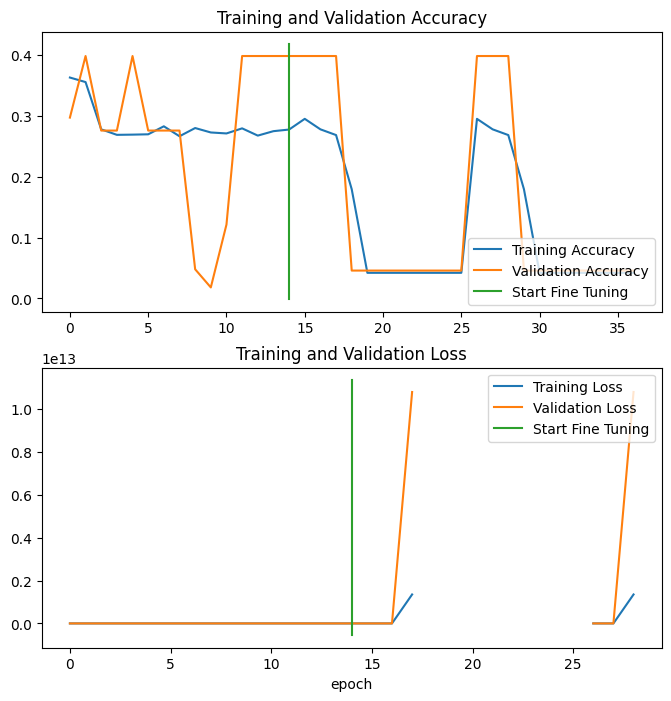

In [58]:
# Plotting the model performance after finetuning
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()
